In [1]:
%matplotlib inline
# Dans le cas de jeux de données de grandes dimensions, une bonne idée est de réduire le nombre de dimension 
# pour se concentrer sur celles qui apportent le plus.
# Pour sélectionner ces "bonnes" caractéristiques, on peut utiliser les stratégies suivantes : 
# - statistiques univariées
# - sélection basée sur le modèle
# - sélection itérative

In [16]:
# Dans la sélection par 📊 univariées, on cherche par analyse de variance, s'il existe une 
# relation statistiquement signifiante entre les caractéristiques prises individuellement et la 🎯 
# Les caractéristiques informatives lorsque combinées avec d'autres sont rejetées.

from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
import numpy as np

cancer_dataset = load_breast_cancer()
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer_dataset.data), 50))
X_with_noise = np.hstack([cancer_dataset.data,noise])

X_train,X_test,y_train,y_test = train_test_split(X_with_noise, cancer_dataset.target,
                                                random_state=0, test_size=.5)
select_uni = SelectPercentile(percentile=50)
select_uni.fit(X_train,y_train)
X_train_selected = select_uni.transform(X_train)

print("Caracteristiques shape : {}".format(X_train.shape))
print("Caracteristiques exraites shape : {}".format(X_train_selected.shape))

Caracteristiques shape : (284, 80)
Caracteristiques exraites shape : (284, 40)


([], [])

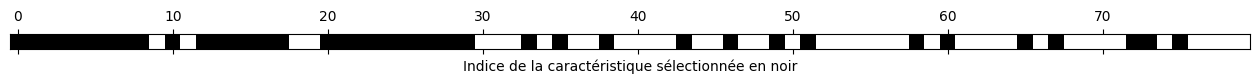

In [17]:
# Quelles sont les caractéristiques qui ont été sélectionnées ?

import matplotlib.pyplot as plt

mask = select_uni.get_support()
plt.matshow(mask.reshape(1,-1),cmap='gray_r')
plt.xlabel("Indice de la caractéristique sélectionnée en noir")
plt.yticks(())

In [18]:
# Peut-on comparer les modèles d'apprentissage par régression logistique 
# sur les données avec bruit et sélectionnées ?

from sklearn.linear_model import LogisticRegression

X_test_selected = select_uni.transform(X_test)

lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
print("Score pour les données avec bruit : {:,.3f}".format(lr.score(X_test,y_test)))
lr.fit(X_train_selected, y_train)
print("Score pour les données sélectionnées : {:,.3f}".format(lr.score(X_test_selected,y_test)))

Score pour les données avec bruit : 0.930
Score pour les données sélectionnées : 0.940


In [19]:
# On peut aussi sélectionner les caractéristiques en utilisant un modèle antrainné offrant une mesure 
# de l'importance des caractéristiques dans la construction du modèle.

# On se propose de sélectionner la moitié des caractéristiques utilisées pour la construction du modèle de forêt
# aléatoire dans l'ordre d'importance donnée par l'attribut feature_importances_

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

select_mod = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

# On extrait les caractéristiques depuis le jeu d'entraînement
select_mod.fit(X_train,y_train)
X_train_l1 = select_mod.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


([], [])

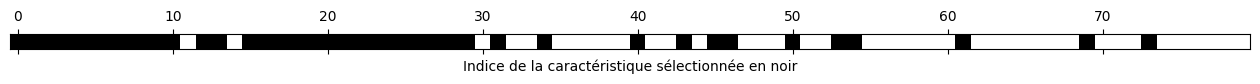

In [20]:
# Soit la sélection suivante : 
mask = select_mod.get_support()
plt.matshow(mask.reshape(1,-1),cmap='gray_r')
plt.xlabel("Indice de la caractéristique sélectionnée en noir")
plt.yticks(())

In [25]:
# Calcul des scores
X_test_l1 = select_mod.transform(X_test)
score = LogisticRegression(solver='liblinear').fit(X_train_l1,y_train).score(X_test_l1,y_test)
print("Score :  {:.3f}".format(score))

Score :  0.954


Text(0.5, 0, 'Indice de la caractéristique sélectionnée en noir')

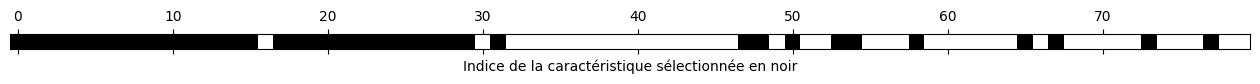

In [29]:
# Plutôt que d'extraire les caractéristiques d'un modèle en se servant du degré d'importance mesuré par ses soins,
# on peut constuire un modèle en itérant soit en ajoutant soit en retirant des caractéristiques.
# Recursive Feature Elimination part de toutes les caractéristiques et les discriminent les unes après les autres
# au fur et à mesure de la construction des modèles associés au nombre. L'algo s'arrête à un seuil. 
# C'est glouton.

from sklearn.feature_selection import RFE
select_rfe = RFE(RandomForestClassifier(n_estimators=100, random_state=42), 
            n_features_to_select=40)
select_rfe.fit(X_train,y_train)
mask_rfe = select_rfe.get_support()
plt.matshow(mask_rfe.reshape(1,-1),cmap='gray_r')
plt.yticks(())
plt.xlabel("Indice de la caractéristique sélectionnée en noir")

In [31]:
# A partir du modèle entraîné, on peut soit extraire les caractéristiques et les utiliser pour entraîner un autre 
# modèle. Soit scorer directement depuis le modèle
X_train_rfe = select_rfe.transform(X_train)
X_test_rfe = select_rfe.transform(X_test)

score = LogisticRegression(solver='liblinear'
                          ).fit(X_train_rfe, y_train
                               ).score(X_test_rfe,y_test)
print("Score LinearRegression : {:.3f}".format(score))
print("RFE score : {:.3f}".format(select_rfe.score(X_test,y_test)))

Score LinearRegression : 0.951
RFE score : 0.951


([], [])

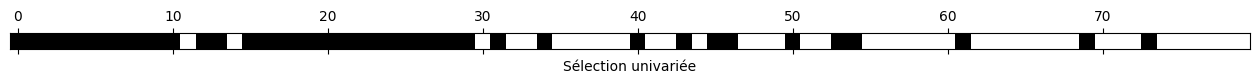

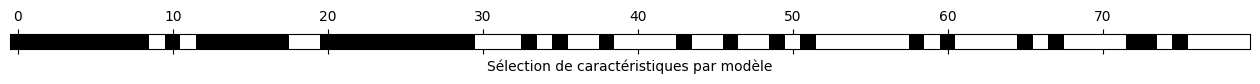

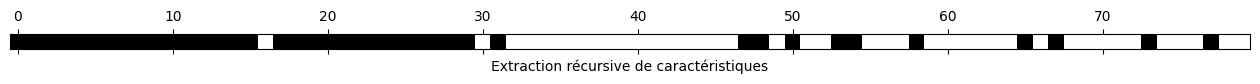

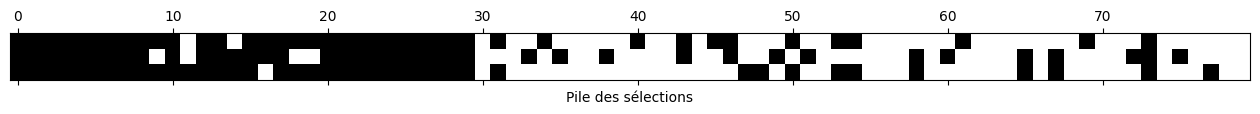

In [54]:
# En stackant les graphes de sélections

mask_mod = select_mod.get_support()
mask_uni = select_uni.get_support()
mask_rfe = select_rfe.get_support()

plt.matshow(mask_mod.reshape(1,-1),cmap='gray_r')
plt.xlabel("Sélection univariée")
plt.yticks(())
plt.matshow(mask_uni.reshape(1,-1),cmap='gray_r')
plt.xlabel("Sélection de caractéristiques par modèle")
plt.yticks(())
plt.matshow(mask_rfe.reshape(1,-1),cmap='gray_r')
plt.xlabel("Extraction récursive de caractéristiques")
plt.yticks(())

import numpy as np
hello = np.hstack([mask_mod.reshape(80,1),mask_uni.reshape(80,1), mask_rfe.reshape(80,1)])
plt.matshow(np.transpose(hello),cmap='gray_r')
plt.xlabel("Pile des sélections")
plt.yticks(())